In [27]:
%matplotlib inline
import collections
import itertools
import matplotlib.pyplot as plt
import nash
import numpy as np

# Nash equilibria

We will investigate these games by considering Nash equilibria: pairs of strategies from which no one has a reason to deviate.

## [The Travellers Dilemma](https://en.wikipedia.org/wiki/Traveler's_dilemma)

From wikipedia:

> An airline loses two suitcases belonging to two different travelers. Both suitcases happen to be identical and contain identical antiques. An airline manager tasked to settle the claims of both travelers explains that the airline is liable for a maximum of $100 per suitcase—he is unable to find out directly the price of the antiques.

> To determine an honest appraised value of the antiques, the manager separates both travelers so they can't confer, and asks them to write down the amount of their value at no less than \$2 and no larger than \$100. He also tells them that if both write down the same number, he will treat that number as the true dollar value of both suitcases and reimburse both travelers that amount. However, if one writes down a smaller number than the other, this smaller number will be taken as the true dollar value, and both travelers will receive that amount along with a bonus/malus: \$2 extra will be paid to the traveler who wrote down the lower value and a \$2 deduction will be taken from the person who wrote down the higher amount. The challenge is: what strategy should both travelers follow to decide the value they should write down?

If we consider a smaller version of this game with the max value being \$4 we have:

$$
\begin{pmatrix}                                                                                                         
2,2&4,0&4,0\\                                                                                                           
0,4&3,3&5,1\\                                                                                                           
0,4&1,5&4,4                                                                                                             
\end{pmatrix} 
$$

Let us use [Nashpy](https://github.com/drvinceknight/Nashpy) to compute the Nash equilibria for this game:

In [28]:
td = (np.array([[2, 4, 4], 
                [0, 3, 5], 
                [0, 1, 4]]), 
      np.array([[2, 0, 0], 
                [4, 3, 1], 
                [4, 5, 4]]))
game = nash.Game(*td)
list(game.equilibria())

[(array([ 1.,  0.,  0.]), array([ 1.,  0.,  0.]))]

The Nash equilibria is for both players to play the first strategy.

## [Rock Paper Scissors Lizard Spock](http://www.samkass.com/theories/RPSSL.html)

This game can be represented as:

$$
\begin{pmatrix}                                                                                                             
0,0 & -1,1 & 1,-1 & 1,-1 & -1,1\\                                                                                           
1,-1 & 0,0 & -1,1 & -1,1 & 1,-1\\                                                                                           
-1,1 & 1,-1 & 0,0 & 1,-1 & -1,1\\                                                                                           
-1,1 & 1,-1 & -1,1 & 0,0 & 1,-1\\                                                                                           
1,-1 & -1,1 & 1,-1 & -1,1 & 0,0                                                                                             
\end{pmatrix}
$$

Let us consider the Nash equilibria:

In [29]:
rpsls = np.array([[0, -1, 1, 1, -1],
                  [1, 0, -1, -1, 1],
                  [-1, 1, 0, 1, -1],
                  [-1, 1, -1, 0, 1],
                  [1, -1, 1, -1, 0]])
rpsls = (rpsls, -rpsls)

game = nash.Game(*rpsls)
list(game.equilibria())

[(array([ 0.2,  0.2,  0.2,  0.2,  0.2]),
  array([ 0.2,  0.2,  0.2,  0.2,  0.2]))]

The Nash equilibria is for both players to play randomly (with equal probability).

# Genetic Algorithms

Below is some basic Python code to implement a genetic algorithm:

In [30]:
def get_population(number_of_strategies, size=50):
    """
    Obtain a random population of strategies for a game.
    """
    population = np.random.randint(0, number_of_strategies, size)
    return population

In [31]:
population = get_population(3, 10)
population

array([2, 0, 2, 1, 0, 0, 2, 0, 2, 2])

In [32]:
def get_scores(population, opponents, game):
    """
    Score all the strategies
    """
    return [(game[0][i, j], game[1][i, j])  
            for i, j in zip(population, opponents)]

In [33]:
opponents =  get_population(3, 10)
scores = get_scores(population, opponents, td)
scores

[(4, 4),
 (2, 2),
 (1, 5),
 (0, 4),
 (4, 0),
 (4, 0),
 (4, 4),
 (4, 0),
 (0, 4),
 (1, 5)]

In [34]:
def mutate(scores, population, opponents):
    """
    Mutate the strategies, this is a naive approach: 
    if a strategy was beaten it mutates to its opponent.
    """
    mutated_population = []
    
    for score, strategy_pair in zip(scores, zip(population, opponents)):

        if score[1] >= score[0]:            
            mutated_population.append(strategy_pair[1])
        else:
            mutated_population.append(strategy_pair[0])
            
    return np.array(mutated_population)

In [35]:
mutate(scores, population, opponents)

array([2, 0, 1, 0, 0, 0, 2, 0, 0, 1])

In [36]:
def evolve(game, size, generations):
    """
    Evolve a population of strategies.
    """
    population = get_population(len(game[0]), size)
    opponents = get_population(len(game[0]), size)
    
    history = [population]

    for _ in range(generations):
        scores = get_scores(population, opponents, game)
        population = mutate(scores, population, opponents)
        opponents = get_population(len(game[0]), size)
        history.append(population)
    
    return history

def plot_history(history, game, ax, legend=True):
    """Plot the history of a genetic algorithm"""
    number_of_strategies = len(game[0])
    counts = [collections.Counter(population) for population in history]
    for strategy in range(number_of_strategies):
        ax.plot([generation[strategy] for generation in counts], label=strategy)
    if legend:
        ax.legend();

Here is the output of this code applied to the travellers Dilemma:

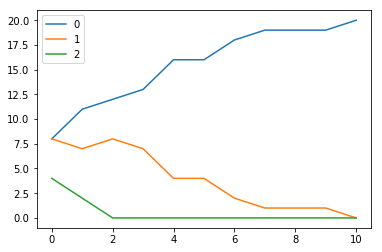

In [37]:
generations = 10
size = 20

fig, ax = plt.subplots(1)
history = evolve(game=td, size=size, generations=generations)
plot_history(history, td, ax);

Here is the output of this code applied to rock paper scissors lizard spock:

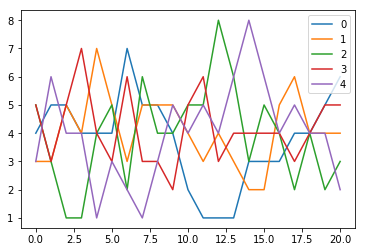

In [38]:
generations = 20
size = 20

fig, ax = plt.subplots(1)
history = evolve(game=rpsls, size=size, generations=generations)
plot_history(history, rpsls, ax);

Let us investigate is this effect is due to the randomness of the algorithm:

In [ ]:
fig, axarr = plt.subplots(4, 4)
coords = list(itertools.product(range(4), range(4)))
for seed, coord in enumerate(coords):
    np.random.seed(seed)
    history = evolve(game=td, size=size, generations=generations)
    title = "Random seed: {}".format(seed)
    plot_history(history, td, axarr[coord[0], coord[1]], legend=False)
    axarr[coord[0], coord[1]].set_title(title, fontsize=6)
    axarr[coord[0], coord[1]].set_yticks([])
    axarr[coord[0], coord[1]].set_xticks([])
plt.tight_layout()
plt.savefig("static/td_16.svg")

In [ ]:
fig, axarr = plt.subplots(4, 4)
coords = list(itertools.product(range(4), range(4)))
for seed, coord in enumerate(coords):
    np.random.seed(seed)
    history = evolve(game=rpsls, size=size, generations=generations)
    title = "Random seed: {}".format(seed)
    plot_history(history, rpsls, axarr[coord[0], coord[1]], legend=False)
    axarr[coord[0], coord[1]].set_title(title, fontsize=6)
    axarr[coord[0], coord[1]].set_yticks([])
    axarr[coord[0], coord[1]].set_xticks([])
plt.tight_layout()
plt.savefig("static/rpsls_16.svg")